<a href="https://colab.research.google.com/github/kiryu-3/Prmn2023/blob/main/Python/Python_Machine/Machine_Learning_9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 主成分分析ー実践編

In [ ]:
# 最初にインポートしてください
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml, load_iris
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import statsmodels.api as sma
from scipy.stats import hmean

今回は、**MNIST**という0から9の手書き文字のデータセットを使って、  
これらの画像の分類を機械学習で行っていきます。

使う機械学習モデルはロジスティック回帰です。



[ヒノマルクさんのこちらの記事](https://www.hinomaruc.com/use-mnist-dataset-to-detect-handwritten-numbers-using-neural-networks/#toc1)にも、MNISTデータセットの説明があります。

## 0.モデル作成の手順

モデル作成を行うまでは、以下のような一連の手順を踏むと良いようです。

1. 問題を定義する<small>（何を知ればよいかを決める）</small>
2. データを入手する<small>（データを入手する）</small>
3. データを確認する<small>（実際にデータを確認・分析して項目同士の関係性や影響の有りそうな項目を見つける）</small>
4. データを整備する<small>（確認した結果、整備すべきものを整備する）</small>
4. 学習用・テスト用データに分割する<small>（モデル作成後に精度を検証するためデータ全体を分割しておきテスト用データを確保する）</small>
5. モデルを構築する<small>（適切な手法を選択しモデルを作成する）</small>
6. モデルを評価する<small>（退避させておいたテスト用データを作成したモデルに読み込ませて結果が正しく出るか精度を確認する）</small>

## 1.問題を定義する

今回から取り組む問題を整理すると、以下のようになります。

> <font color=blue>MNISTデータセットから、その画像に書かれている数字を分類する</font>

手書き文字の画像を0〜9のクラスに分類していきます。


##2.データを用意する

### 2-1.データを入手する


今回は、OpenMLと呼ばれるオンラインのデータセットリポジトリからデータセットをダウンロードします。
MNISTデータセットを取得し情報を表示します。  
（取得には少し時間がかかります）

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 418.7 MB


データの件数は70000、データのカラム数は784でした。

先頭5件だけ取得してみます。



In [ ]:
mnist.data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


それぞれのピクセルがpixel1〜pixel784のように、  
784個の特徴量として扱える形になっていることが分かります。


## 3.データを確認する

統計量を取得してみましょう。

In [ ]:
mnist.data.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


ピクセル値は大体0〜254あたりになります。

通常ピクセルの値は8bit(0～255)で表され、  
0が真っ黒で、値が増えるほど白くなり、255で真っ白になります。  


pixel1～10や、pixel781～784は画像の端っこになるので、   
どの画像でも黒(0)で最小値も最大値も0になっています。

それぞれのデータの正解ラベルは `.target` でアクセスできます。

In [ ]:
mnist.target

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

一番上の"5"の手書き画像を実際に表示してみます。

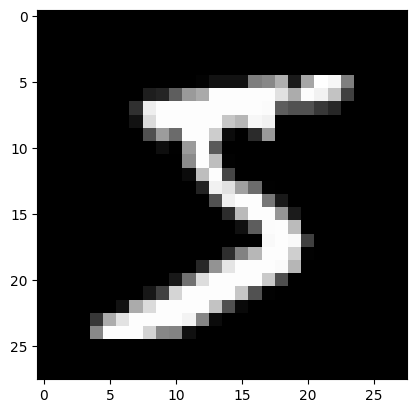

In [ ]:
im = mnist.data.iloc[0].values.reshape(28, 28)
plt.imshow(im, 'gray')

多くのピクセルが黒(0)なのが分かります。

## 4.データを整備する

今回は特に何も行いません。

## 5.学習用・テスト用データに分割する

hold-out法で、整備したデータを  
「学習用データ」と「テスト用データ」に分割します。

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target)

## 6.モデルを作成する（PCAなし）

前処理とモデルを一つのオブジェクトとして扱うことができるpipelineを使って、  
いよいよ、ロジスティック回帰を行っていきます。

今回は、学習にかかる時間も測ります。

In [ ]:
import time

# Pipelineを定義
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # データの標準化
    ('model', LogisticRegression(penalty='none', multi_class='multinomial'))  # ロジスティック回帰モデル
])
before = time.time()
pipeline.fit(X_train, y_train)
after = time.time()
print(f"fit took {after-before:.2f}s")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


fit took 35.55s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


学習に35秒近くかかってしまいました。

##  7.モデルを評価する（PCAなし）

AUCを使って、モデルの評価を行います。

In [ ]:
y_pred = pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## 6.モデルを作成する（PCAあり）

前処理とモデルを一つのオブジェクトとして扱うことができるpipelineを使って、  
次は、PCAをして次元を削減した後でロジスティック回帰を行っていきます。

今回も、学習にかかる時間も測ります。

In [ ]:
# パイプラインの構築
# 1. データの標準化（必要な場合）
# 2. PCAによる次元削減
pipeline_pc = Pipeline([
    ('scaler', StandardScaler()),  # データの標準化
    ('pca', PCA(n_components=0.95))  # PCAによる次元削減
])

# パイプラインを訓練データに適用
pipeline_pc.fit(X_train)

# 訓練データとテストデータをPCAで変換
X_train_pc = pipeline_pc.transform(X_train)
X_test_pc = pipeline_pc.transform(X_test)

print(f'{X_train.shape[-1]} dimention is reduced to {X_train_pc.shape[-1]} dimention by PCA')

784 dimention is reduced to 326 dimention by PCA


PCAをした結果、784次元を323次元に削減することができました。

In [ ]:
import time

# Pipelineを定義
pipeline = Pipeline([
    # ('scaler', StandardScaler()),  # データの標準化（今回は不要）
    ('model', LogisticRegression(penalty='none', multi_class='multinomial'))  # ロジスティック回帰モデル
])
before = time.time()
pipeline.fit(X_train_pc, y_train)
after = time.time()
print(f"fit took {after-before:.2f}s")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


fit took 14.58s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


学習に15秒近くかかるという結果となりましたが、  
半分以上の時間短縮を実現できました。

##  7.モデルを評価する（PCAあり）

AUCを使って、モデルの評価を行います。

In [ ]:
y_pred = pipeline.predict(X_test_pc)
accuracy_score(y_test, y_pred)

0.9221714285714285

ほんのわずかですが、PCAをしなかった場合に比べて精度が向上したようです。

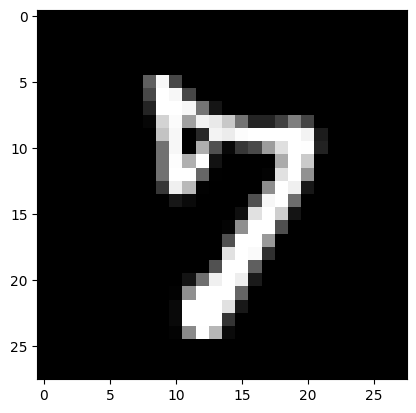

In [ ]:
# 画像再構成

index = 0
im = X_test.iloc[index].values.reshape(28, 28)
plt.imshow(im, 'gray')

In [ ]:
index = 0
y_test.iloc[index]

'7'

In [ ]:
index = 0
y_pred[0]

'7'

一番最初のデータに関しては、正しく予測できたようです。